# Imputing missing values  
sources: 
* [scikit-learn.org](https://scikit-learn.org/stable/modules/impute.html)
* [scikit-learn.org - example](https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html#sphx-glr-auto-examples-impute-plot-iterative-imputer-variants-comparison-py)
* [analyticsvidhya.com](https://www.analyticsvidhya.com/blog/2021/05/dealing-with-missing-values-in-python-a-complete-guide/)

### Imputing missing values with variants of IterativeImputer - scikit learn  
The IterativeImputer class is very flexible - it can be used with a `variety of estimators` to do round-robin regression, treating every variable as an output in turn.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

/Users/oliverdreger/opt/anaconda3/envs/omd2022/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/oliverdreger/opt/anaconda3/envs/omd2022/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/oliverdreger/opt/anaconda3/envs/omd2022/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/oliverdreger/opt/anaconda3/envs/omd2022/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/oliverdreger/opt/anaconda3/envs/omd2022/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

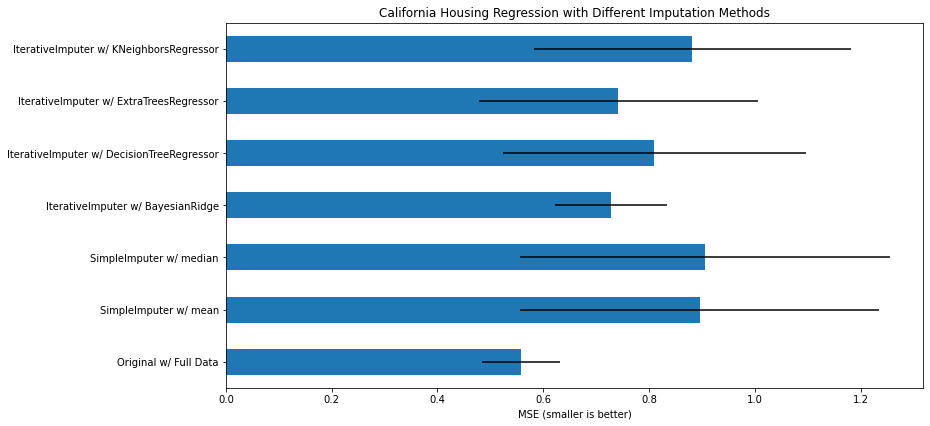

In [64]:
N_SPLITS = 5

rng = np.random.RandomState(0)

X_full, y_full = fetch_california_housing(return_X_y=True)
# ~2k samples is enough for the purpose of the example.
# Remove the following two lines for a slower run with different error bars.
# X_full = X_full[::10]
# y_full = y_full[::10]
n_samples, n_features = X_full.shape

# Estimate the score on the entire dataset, with no missing values
br_estimator = BayesianRidge()
score_full_data = pd.DataFrame(
    cross_val_score(
        br_estimator, X_full, y_full, scoring="neg_mean_squared_error", cv=N_SPLITS
    ),
    columns=["Full Data"],
)

# Add a single missing value to each row
X_missing = X_full.copy()
y_missing = y_full
missing_samples = np.arange(n_samples)
missing_features = rng.choice(n_features, n_samples, replace=True)
X_missing[missing_samples, missing_features] = np.nan

# Estimate the score after imputation (mean and median strategies)
score_simple_imputer = pd.DataFrame()
for strategy in ("mean", "median"):
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy), br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_mean_squared_error", cv=N_SPLITS
    )

# Estimate the score after iterative imputation of the missing values
# with different estimators
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features="sqrt", random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=15),
]
score_iterative_imputer = pd.DataFrame()
for impute_estimator in estimators:
    estimator = make_pipeline(
        IterativeImputer(random_state=0, estimator=impute_estimator), br_estimator
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_mean_squared_error", cv=N_SPLITS
    )

scores = pd.concat(
    [score_full_data, score_simple_imputer, score_iterative_imputer],
    keys=["Original", "SimpleImputer", "IterativeImputer"],
    axis=1,
)

# plot california housing results
fig, ax = plt.subplots(figsize=(13, 6))
means = -scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title("California Housing Regression with Different Imputation Methods")
ax.set_xlabel("MSE (smaller is better)")
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels([" w/ ".join(label) for label in means.index.tolist()])
plt.tight_layout(pad=1)
plt.show()

In [97]:
scores

Original SimpleImputer           IterativeImputer                        \
  Full Data          mean    median    BayesianRidge DecisionTreeRegressor   
0 -0.484400     -0.633233 -0.652143        -0.570935             -0.619494   
1 -0.622683     -0.764850 -0.769493        -0.733662             -0.680309   
2 -0.646209     -0.810675 -0.812903        -0.753755             -0.761044   
3 -0.543514     -0.780172 -0.771061        -0.717884             -0.673045   
4 -0.494590     -1.489357 -1.522480        -0.865115             -1.313990   

                                           
  ExtraTreesRegressor KNeighborsRegressor  
0           -0.551549           -0.632240  
1           -0.648713           -0.774868  
2           -0.701790           -0.807917  
3           -0.604992           -0.790789  
4           -1.202495           -1.404721

/Users/oliverdreger/opt/anaconda3/envs/omd2022/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


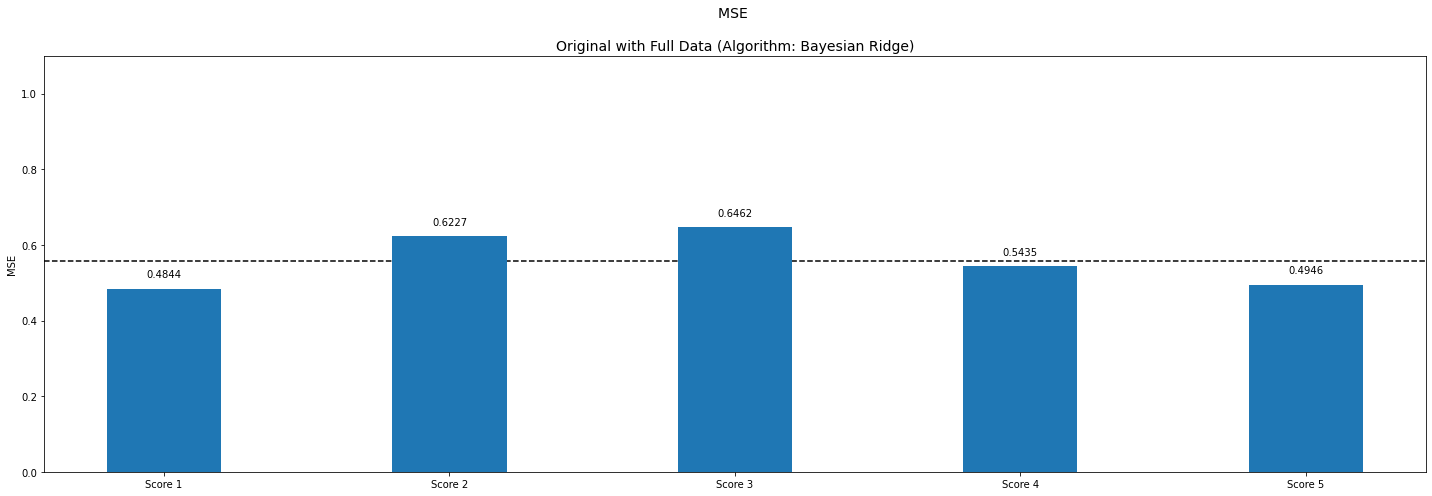

In [61]:
fig, ax = plt.subplots(figsize=(20, 7))

x_vals = []

for i in range(score_full_data.shape[0]):
    x_vals.append('Score '+ str(i+1))

x = x_vals
y = list(score_full_data.values[:,0]* (-1)) 

ax.bar(x, y, width=0.4, zorder=10)
# ax.set_xlabel('Scores')

ax.set_ylabel('MSE')
ax.set_ylim(0, 1.1)
ax.set_title('MSE \n\nOriginal with Full Data (Algorithm: Bayesian Ridge)', fontsize=14)
ax.axhline(abs(np.mean(score_full_data)).values[0], color='black', ls='--', zorder=2)

for index, value in enumerate(y):
    if value >= 0:
        plt.text(x=index, y=value + 0.03, s=str(round(value,4)), ha='center')
    else:
        plt.text(x=index, y=value - 0.06, s=str(round(value,4)), ha='center')

plt.tight_layout()

In [62]:
score_simple_imputer

,mean,median
0,-0.633233,-0.652143
1,-0.764850,-0.769493
2,-0.810675,-0.812903
3,-0.780172,-0.771061
4,-1.489357,-1.522480


## Build a DataFrame object

In [82]:
cal_housing = fetch_california_housing(as_frame=True)
housing = cal_housing.data
housing[cal_housing.target_names[0]] = cal_housing.target
housing

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [90]:
print(cal_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [96]:
print('Median House Value: ${0:,.0f}'.format(housing.MedHouseVal.mean() * 100000))

Median House Value: $206,856
